In [1]:
import sys
import importlib
import gc
import glob
from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics
import kmedoids

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [5]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
plt.rcParams["text.usetex"] = True

In [6]:
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [7]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_01.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_02.npy", allow_pickle=True)
)

In [8]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [9]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
for i in range(6):
    sb_trajs.extend(
        np.load(f"../../data/raw_feat/feat2_suppl_{i:02d}.npy", allow_pickle=True)
    )

In [10]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3729000, 2) (3729000, 60)


In [11]:
traj_files = np.loadtxt("../../data/suppl_traj_files.txt", dtype=str)

# K-means

In [12]:
from sklearn.cluster import _kmeans
from sklearn.metrics import pairwise_distances

In [71]:
def kmpp(X, k):
    n_row, n_col = X.shape

    # randomly choose the first centroid
    centroids = np.zeros((k, n_col))
    rand_index = np.random.choice(n_row)
    centroids[0] = X[rand_index]

    # compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(
        X, [centroids[0]], metric="euclidean", n_jobs=-1
    ).flatten()

    for i in range(1, k):
        # choose the next centroid, the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid
        prob = distances ** 2
        rand_index = np.random.choice(n_row, size=1, p=prob / np.sum(prob))
        centroids[i] = X[rand_index]

        if i == k - 1:
            break

        # if we still need another cluster,
        # compute distances from the centroids to all data points
        # and update the squared distance as the minimum distance to all centroid
        distances_new = pairwise_distances(
            X, [centroids[i]], metric="euclidean", n_jobs=-1
        ).flatten()
        distances = np.min(np.vstack((distances, distances_new)), axis=0)
    return centroids

In [102]:
def km_regularized(data, k, lag, centroids=None, lmbda=0.1, max_iter=10, tol=1e-3):
    # convert lists of trajectories into array
    X = np.concatenate(data)
    traj_inds = np.cumsum([len(traj) for traj in data])[:-1]

    # initialize
    if centroids is None:
        print("Performing initialization with k-means++...")
        centroids = kmpp(X, k)
        print("Initialization completed")

    print("Starting k-means algorithm...")
    for itr in range(max_iter):
        print(f"Performing iteration {itr + 1}")
        # compute distances between each data point and the set of centroids
        distances_to_centroids = pairwise_distances(
            X, centroids, metric="euclidean", n_jobs=-1
        )
        # initial assignments
        cluster_assignment = np.argmin(distances_to_centroids, axis=1)
        print(cluster_assignment)

        # include cost using transition matrix
        dtrajs = np.split(cluster_assignment, traj_inds)
        cmat = msmtools.estimation.count_matrix(dtrajs, lag=lag, nstates=k)
        tmat = msmtools.estimation.transition_matrix(cmat, reversible=True)
        inv_diag = 1 / (1 - tmat.diagonal())
        costs = (1 - lmbda) * distances_to_centroids + lmbda * inv_diag

        # assign each data point to the closest centroid
        new_cluster_assignment = np.argmin(costs, axis=1)

        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array(
            [X[cluster_assignment == i].mean(axis=0) for i in range(k)]
        )

        # if assignments are the same, then converged
        if np.all(cluster_assignment == new_cluster_assignment):
            print("Converged.")
            break

        centroids = new_centroids
        cluster_assignment = new_cluster_assignment

    dtrajs = np.split(cluster_assignment, traj_inds)
    return centroids, dtrajs

In [ ]:
# def tmat(dtrajs)
#     C = msmtools.estimation.count_matrix(dtraj, )
#     tmat = msmtools.estimation.transition_matrix(reversible=True)

# tests

In [24]:
%timeit kmpp(sb_arr[:100], 50)

5.38 s ± 801 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%timeit centroids, dist = kmpp(sb_arr[:1000], 50)

5.37 s ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
centroids, dist = kmpp(sb_arr[:1000], 10)

In [67]:
dist.shape

(1000,)

In [83]:
X = sb_arr[:1000]

In [84]:
distances_to_centroids = pairwise_distances(X, centroids, metric="euclidean", n_jobs=-1)

In [85]:
cluster_assignment = np.argmin(distances_to_centroids, axis=1)

In [86]:
cluster_assignment.shape

(1000,)

In [87]:
cluster_assignment

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 8, 9, 8, 9, 8, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9, 9,
       9, 3, 2, 9, 8, 9, 9, 8, 9, 9, 9, 9, 2, 1, 9, 9, 1, 1, 8, 8, 8, 8,
       8, 8, 2, 8, 8, 2, 8, 2, 8, 8, 8, 8, 8, 9, 2, 2, 7, 8, 7, 8, 8, 2,
       2, 8, 8, 9, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 2, 7, 2, 2, 2, 2,
       8, 8, 8, 8, 8, 8, 8, 2, 8, 2, 0, 7, 8, 8, 6, 2, 6, 2, 8, 2, 2, 8,
       2, 9, 9, 8, 8, 9, 9, 8, 1, 1, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 3, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       3, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 1, 2, 8, 2, 3, 8, 9, 8, 8, 1, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8,

In [88]:
k = 10
lmbda = 0.1
cmat = msmtools.estimation.count_matrix(cluster_assignment, lag=1, nstates=k)
tmat = msmtools.estimation.transition_matrix(cmat, reversible=True)
inv_diag = 1 / (1 - tmat.diagonal())
costs = (1 - lmbda) * distances_to_centroids + lmbda * inv_diag

In [89]:
tmat.diagonal()

array([0.82741117, 0.58139535, 0.66666667, 0.88135593, 0.69473684,
       0.76086957, 0.45714286, 0.71875   , 0.77714286, 0.63265306])

In [90]:
inv_diag.shape

(10,)

In [91]:
costs.shape

(1000, 10)

In [92]:
cluster_assignment = np.argmin(costs, axis=1)

In [78]:
cluster_assignment

array([3, 2, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 9, 3, 2, 2, 2, 3, 9,
       3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 9, 9, 8, 9, 3, 9, 3, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 1, 1, 9, 1, 1, 9, 1, 1, 1,
       9, 2, 2, 2, 2, 2, 6, 2, 8, 2, 2, 9, 2, 9, 2, 2, 6, 2, 6, 6, 6, 6,
       2, 6, 6, 9, 6, 2, 6, 8, 6, 9, 2, 2, 2, 6, 7, 8, 2, 2, 2, 2, 2, 2,
       2, 6, 9, 2, 2, 9, 6, 2, 6, 2, 6, 6, 2, 6, 6, 6, 6, 2, 6, 2, 2, 2,
       2, 9, 9, 9, 9, 9, 9, 1, 1, 1, 8, 9, 9, 9, 9, 1, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 8, 8, 1,
       8, 8, 2, 1, 8, 1, 8, 1, 1, 1, 1, 8, 8, 8, 8, 8, 1, 8, 9, 8, 8, 8,
       9, 2, 9, 9, 8, 1, 6, 8, 6, 1, 1, 1, 6, 1, 2, 9, 1, 1, 8, 1, 1, 1,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6,
       8, 8, 1, 8, 1, 8, 6, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 9,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 8, 1, 1,

In [93]:
new_centroids = np.array([X[cluster_assignment == i].mean(axis=0) for i in range(k)])

In [94]:
np.abs(centroids - new_centroids)

array([[9.72521305e-03, 7.08044767e-02, 2.33452320e-02, 5.06377220e-03,
        9.73701477e-03, 5.45811653e-03, 6.92921877e-03, 4.87631559e-02,
        1.00300312e-02, 1.00597143e-02, 7.26342201e-04, 1.06834769e-02,
        4.95457649e-03, 3.57736349e-02, 2.80539989e-02, 1.99455023e-02,
        1.53682232e-02, 3.39205265e-02, 1.31355524e-02, 5.70440292e-03,
        1.85806751e-02, 1.98861361e-02, 1.47166252e-02, 1.80283785e-02,
        4.20737267e-02, 1.66759491e-02, 3.63039970e-03, 2.25696564e-02,
        7.37261772e-03, 5.09977341e-04, 2.92298794e-02, 1.65008307e-02,
        1.11562014e-02, 1.23751163e-02, 4.43956852e-02, 4.14052010e-02,
        1.68383121e-03, 8.15427303e-03, 2.67578363e-02, 5.54485321e-02,
        3.55764627e-02, 4.14366722e-02, 2.27068067e-02, 2.45091915e-02,
        5.26196957e-02, 9.21660662e-03, 2.33040452e-02, 1.21960044e-03,
        2.72047520e-03, 1.45673752e-02, 4.03201580e-02, 1.84147358e-02,
        1.92648172e-03, 1.72160864e-02, 4.70278263e-02, 9.623169

In [95]:
centroids = new_centroids

In [96]:
distances_to_centroids = pairwise_distances(X, centroids, metric="euclidean", n_jobs=-1)

In [97]:
cluster_assignment = np.argmin(distances_to_centroids, axis=1)

In [98]:
cmat = msmtools.estimation.count_matrix(cluster_assignment, lag=1, nstates=k)
tmat = msmtools.estimation.transition_matrix(cmat, reversible=True)
inv_diag = 1 / (1 - tmat.diagonal())
costs = (1 - lmbda) * distances_to_centroids + lmbda * inv_diag

In [99]:
cluster_assignment = np.argmin(costs, axis=1)

In [104]:
cluster_assignment

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 1, 9, 9, 1, 9, 9, 1, 1, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 1, 2, 9, 8, 9, 9, 6, 9, 1, 2, 6, 1, 6, 6, 6, 6,
       6, 6, 1, 6, 6, 6, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 2, 6, 2, 2, 6, 6,
       8, 1, 9, 9, 9, 9, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 2, 2, 9,
       2, 9, 9, 1, 9, 1, 9, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 1, 1, 9, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 8, 2, 1, 8, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 8, 1,
       9, 9, 9, 9, 8, 1, 6, 6, 1, 1, 1, 1, 1, 1, 1, 9, 1, 9, 1, 1, 1, 1,
       8, 9, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 6, 8,
       8, 8, 1, 1, 1, 8, 1, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 9,
       8, 8, 8, 8, 8, 8, 8, 8, 9, 1, 9, 1, 9, 1, 9,

In [106]:
new_centroids = np.array([X[cluster_assignment == i].mean(axis=0) for i in range(k)])

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.


In [107]:
np.abs(centroids - new_centroids)

array([[1.53850317e-02, 2.58063078e-02, 6.58392906e-04, 6.25443459e-03,
        6.41870499e-03, 1.89137459e-03, 5.68795204e-03, 8.44347477e-03,
        1.24785900e-02, 4.91297245e-03, 1.05049610e-02, 4.91678715e-04,
        7.17604160e-03, 2.60102749e-03, 1.55322552e-02, 8.59737396e-04,
        1.75285339e-02, 8.62491131e-03, 1.90854073e-04, 2.82073021e-03,
        1.15816593e-02, 8.83102417e-03, 2.53497362e-02, 1.32293701e-02,
        2.14576721e-06, 4.91666794e-03, 1.28142834e-02, 2.03380585e-02,
        3.61270905e-02, 1.98898315e-02, 1.39038563e-02, 3.12854052e-02,
        9.65595245e-03, 4.02045250e-03, 1.86362267e-02, 6.28352165e-03,
        1.27483904e-02, 1.63094401e-02, 1.99041367e-02, 3.60131264e-04,
        1.51916742e-02, 6.50286674e-03, 2.14421749e-03, 1.28483772e-02,
        1.25250816e-02, 6.67935610e-03, 1.69891715e-02, 1.15945935e-03,
        6.41608238e-03, 1.99532509e-03, 2.38218307e-02, 4.61471081e-03,
        5.58122396e-02, 1.26129389e-02, 4.21738625e-03, 8.051395

# Double well

In [12]:
double_well_data = np.load("/project2/roux/scguo/toy_models/double_well.npy")
print(double_well_data.shape)

(200000000, 3)


In [40]:
data = [double_well_data[::100, 1:]]

In [41]:
data[0].shape

(2000000, 2)

In [24]:
centroids, assignments = km_regularized(X, 100, 10)

Performing initialization with k-means++...
Initialization completed
Starting k-means algorithm...
Performing iteration 1


AssertionError: C must be strongly connected

In [28]:
k = 100
lag = 10
lmbda = 0.1
max_iter = 10
tol = 1e-3

In [42]:
X = np.concatenate(data)
traj_inds = np.cumsum([len(traj) for traj in data])[:-1]

# initialize
centroids = kmpp(X, k)

In [43]:
centroids.shape

(100, 2)

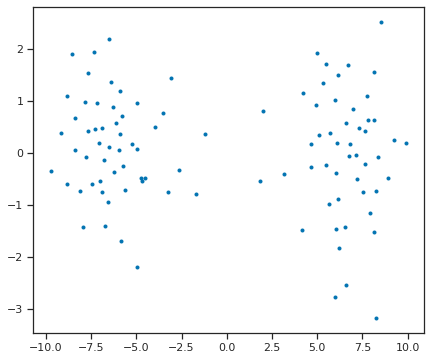

In [45]:
plt.plot(*centroids.T, ".")

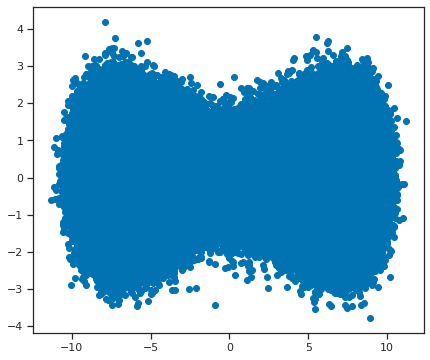

In [47]:
plt.scatter(X[:, 0], X[:, 1])

In [48]:
distances_to_centroids = pairwise_distances(X, centroids, metric="euclidean", n_jobs=-1)
# initial assignments
cluster_assignment = np.argmin(distances_to_centroids, axis=1)
print(cluster_assignment)

[93 93  2 ... 13 89  8]


In [49]:
dtrajs = np.split(cluster_assignment, traj_inds)
cmat = msmtools.estimation.count_matrix(dtrajs, lag=lag, nstates=k)
tmat = msmtools.estimation.transition_matrix(cmat, reversible=True)
inv_diag = 1 / (1 - tmat.diagonal())
costs = (1 - lmbda) * distances_to_centroids + lmbda * inv_diag

In [55]:
inv_diag.shape

(100,)

In [57]:
distances_to_centroids.shape

(2000000, 100)

In [54]:
costs.shape

(2000000, 100)

In [58]:
assignments_wo = np.argmin(distances_to_centroids, axis=1)
assignments_with = np.argmin(costs, axis=1)

In [69]:
np.count_nonzero(assignments_with != assignments_wo)

4306

# Hyperparameters test

In [91]:
init_centroids = kmpp(X, k)

## Scikit-learn

In [94]:
centroids_test, assignments_test, _ = sklearn.cluster.k_means(X, k, init=init_centroids)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:319: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  ).fit(X, sample_weight=sample_weight)


Text(0.5, 1.0, 'Scikit-learn')

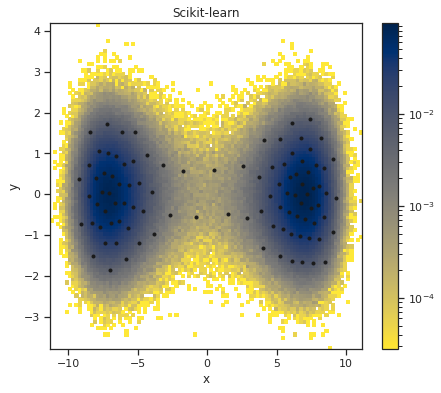

In [96]:
# plot data in phi/psi space
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(*centroids_test.T, ".k")
hist, xe, ye = np.histogram2d(*X.T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(h, ax=ax)
plt.title("Scikit-learn")

## base, k = 100, lag = 10, lambda = 0.1, 10 iterations

In [92]:
centroids, assignments = km_regularized(data, 100, 10, centroids=init_centroids)

Starting k-means algorithm...
Performing iteration 1
[78 32 54 ...  4 46 42]
Performing iteration 2
[32 32 54 ...  4 46 42]
Performing iteration 3
[32 32 54 ...  4 46 42]
Performing iteration 4
[32 32 54 ...  4 46 42]
Performing iteration 5
[32 32 54 ...  4 46 42]
Performing iteration 6
[32 32 54 ...  4 46 42]
Performing iteration 7
[32 32 54 ...  4 46 42]
Performing iteration 8
[32 32 54 ...  4 46 42]
Performing iteration 9
[32 32 54 ...  4 46 42]
Performing iteration 10
[32 32 54 ...  4 46 42]


Text(0.5, 1.0, 'k = 100, lag = 10, lambda = 0.1, 10 iterations')

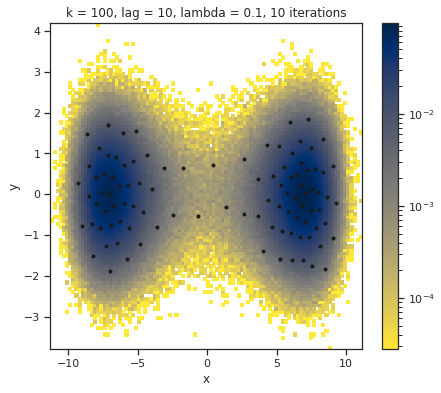

In [93]:
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(*centroids.T, ".k")
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(h, ax=ax)
plt.title("k = 100, lag = 10, lambda = 0.1, 10 iterations")

## 100 iterations

In [98]:
# try with different lambda and longer lag
centroids, assignments = km_regularized(
    data, 100, 10, centroids=init_centroids, max_iter=100
)

Starting k-means algorithm...
Performing iteration 1
[78 32 54 ...  4 46 42]
Performing iteration 2
[32 32 54 ...  4 46 42]
Performing iteration 3
[32 32 54 ...  4 46 42]
Performing iteration 4
[32 32 54 ...  4 46 42]
Performing iteration 5
[32 32 54 ...  4 46 42]
Performing iteration 6
[32 32 54 ...  4 46 42]
Performing iteration 7
[32 32 54 ...  4 46 42]
Performing iteration 8
[32 32 54 ...  4 46 42]
Performing iteration 9
[32 32 54 ...  4 46 42]
Performing iteration 10
[32 32 54 ...  4 46 42]
Performing iteration 11
[32 32 54 ...  4 46 42]
Performing iteration 12
[32 32 54 ...  4 46 42]
Performing iteration 13
[32 32 54 ...  4 46 42]
Performing iteration 14
[32 32 54 ...  4 46 42]
Performing iteration 15
[32 32 54 ...  4 46 42]
Performing iteration 16
[32 32 54 ...  4 46 42]
Performing iteration 17
[32 32 54 ...  4 46 42]
Performing iteration 18
[32 32 54 ...  4 46 42]
Performing iteration 19
[32 32 54 ...  4 46 42]
Performing iteration 20
[32 32 54 ...  4 46 42]
Performing iteratio

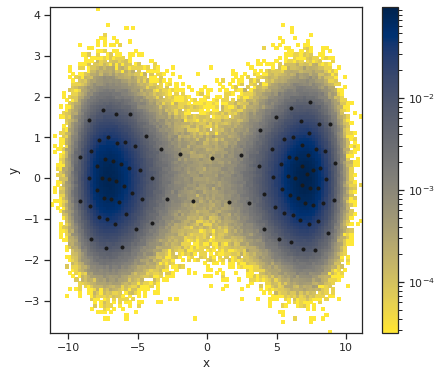

In [99]:
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(*centroids.T, ".k")
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(h, ax=ax)

## lambda = 0.2

In [103]:
# try with different lambda and more iterations
centroids, assignments = km_regularized(
    data, 100, 10, centroids=init_centroids, lmbda=0.2, max_iter=100
)

Starting k-means algorithm...
Performing iteration 1
[78 32 54 ...  4 46 42]
Performing iteration 2
[32 32 54 ...  4 46 42]
Performing iteration 3
[32 32 54 ...  4 46 42]
Performing iteration 4
[32 32 54 ...  4 46 42]
Performing iteration 5
[32 32 54 ...  4 46 42]
Performing iteration 6
[32 32 54 ...  4 46 42]
Performing iteration 7
[32 32 54 ...  4 46 42]
Performing iteration 8
[32 32 54 ...  4 46 42]
Performing iteration 9
[32 32 54 ...  4 46 42]
Performing iteration 10
[32 32 54 ...  4 46 42]
Performing iteration 11
[32 32 54 ...  4 46 42]
Performing iteration 12
[32 32 54 ...  4 46 42]
Performing iteration 13
[32 32 54 ...  4 46 42]
Performing iteration 14
[32 32 54 ...  4 46 42]
Performing iteration 15
[32 32 54 ...  4 46 42]
Performing iteration 16
[32 32 54 ...  4 46 42]
Performing iteration 17
[32 32 54 ...  4 46 42]
Performing iteration 18
[32 32 54 ...  4 46 42]
Performing iteration 19
[32 32 54 ...  4 46 42]
Performing iteration 20
[32 32 54 ...  4 46 42]
Performing iteratio

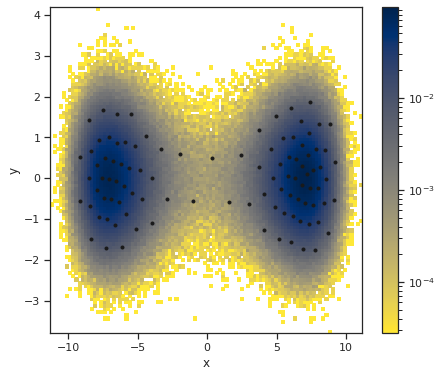

In [104]:
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(*centroids.T, ".k")
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(h, ax=ax)

## lambda = 0.3

In [105]:
centroids, assignments = km_regularized(
    data, 100, 10, centroids=init_centroids, lmbda=0.3, max_iter=100
)

Starting k-means algorithm...
Performing iteration 1
[78 32 54 ...  4 46 42]
Performing iteration 2
[32 32 54 ...  4 46 42]
Performing iteration 3
[32 32 54 ...  4 46 42]
Performing iteration 4
[32 32 54 ...  4 46 42]
Performing iteration 5
[32 32 54 ...  4 46 42]
Performing iteration 6
[32 32 54 ...  4 46 42]
Performing iteration 7
[32 32 54 ...  4 46 42]
Performing iteration 8
[32 32 54 ...  4 46 42]
Performing iteration 9
[32 32 54 ...  4 46 42]
Performing iteration 10
[32 32 54 ...  4 46 42]
Performing iteration 11
[32 32 54 ...  4 46 42]
Performing iteration 12
[32 32 54 ...  4 46 42]
Performing iteration 13
[32 32 54 ...  4 46 42]
Performing iteration 14
[32 32 54 ...  4 46 42]
Performing iteration 15
[32 32 54 ...  4 46 42]
Performing iteration 16
[32 32 54 ...  4 46 42]
Performing iteration 17
[32 32 54 ...  4 46 42]
Performing iteration 18
[32 32 54 ...  4 46 42]
Performing iteration 19
[32 32 54 ...  4 46 42]
Performing iteration 20
[32 32 54 ...  4 46 42]
Performing iteratio

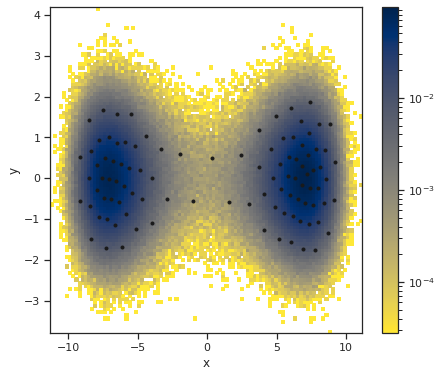

In [106]:
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(*centroids.T, ".k")
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(h, ax=ax)

## lambda = 0.4

In [107]:
centroids, assignments = km_regularized(
    data, 100, 10, centroids=init_centroids, lmbda=0.4, max_iter=100
)

Starting k-means algorithm...
Performing iteration 1
[78 32 54 ...  4 46 42]
Performing iteration 2
[32 32 54 ...  4 46 42]
Performing iteration 3
[32 32 54 ...  4 46 42]
Performing iteration 4
[32 32 54 ...  4 46 42]
Performing iteration 5
[32 32 54 ...  4 46 42]
Performing iteration 6
[32 32 54 ...  4 46 42]
Performing iteration 7
[32 32 54 ...  4 46 42]
Performing iteration 8
[32 32 54 ...  4 46 42]
Performing iteration 9
[32 32 54 ...  4 46 42]
Performing iteration 10
[32 32 54 ...  4 46 42]
Performing iteration 11
[32 32 54 ...  4 46 42]
Performing iteration 12
[32 32 54 ...  4 46 42]
Performing iteration 13
[32 32 54 ...  4 46 42]
Performing iteration 14
[32 32 54 ...  4 46 42]
Performing iteration 15
[32 32 54 ...  4 46 42]
Performing iteration 16
[32 32 54 ...  4 46 42]
Performing iteration 17
[32 32 54 ...  4 46 42]
Performing iteration 18
[32 32 54 ...  4 46 42]
Performing iteration 19
[32 32 54 ...  4 46 42]
Performing iteration 20
[32 32 54 ...  4 46 42]
Performing iteratio

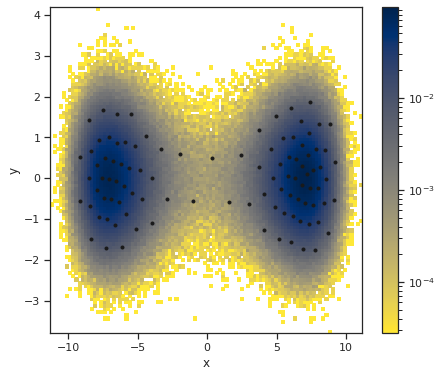

In [108]:
f, ax = plt.subplots(figsize=(7, 6))
ax.plot(*centroids.T, ".k")
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(h, ax=ax)

# lambda = 0.5

In [112]:
centroids, assignments = km_regularized(
    data, 100, 10, centroids=init_centroids, lmbda=0.5, max_iter=100
)

Starting k-means algorithm...
Performing iteration 1
[78 32 54 ...  4 46 42]
Performing iteration 2
[32 32 54 ...  4 46 42]
Performing iteration 3
[32 32 54 ...  4 46 42]
Performing iteration 4
[32 32 54 ...  4 46 42]
Performing iteration 5
[32 32 54 ...  4 46 42]
Performing iteration 6
[32 32 54 ...  4 46 42]
Performing iteration 7
[32 32 54 ...  4 46 42]
Performing iteration 8
[32 32 54 ...  4 46 42]
Performing iteration 9
[32 32 54 ...  4 46 42]
Performing iteration 10
[32 32 54 ...  4 46 42]
Performing iteration 11
[32 32 54 ...  4 46 42]
Performing iteration 12
[32 32 54 ...  4 46 42]
Performing iteration 13
[32 32 54 ...  4 46 42]
Performing iteration 14
[32 32 54 ...  4 46 42]
Performing iteration 15
[32 32 54 ...  4 46 42]
Performing iteration 16
[32 32 54 ...  4 46 42]
Performing iteration 17
[32 32 54 ...  4 46 42]
Performing iteration 18
[32 32 54 ...  4 46 42]
Performing iteration 19
[32 32 54 ...  4 46 42]
Performing iteration 20
[32 32 54 ...  4 46 42]
Performing iteratio

# TICA (IVAC)

In [13]:
livac = ivac.LinearIVAC(minlag=1, maxlag=10000, nevecs=10, reweight=False)
livac.fit(sb_trajs)
ivac_trajs = livac.transform(sb_trajs)
ivac_arr = np.concatenate(ivac_trajs)
print(ivac_arr.shape)

(3729000, 10)


## Clustering with k-means

In [14]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [16]:
k = 1000
kmeans = MiniBatchKMeans(k)
kmeans.fit(ivac_arr)
centers = kmeans.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


NearestNeighbors(n_neighbors=1)

In [17]:
inds = neighbors.kneighbors(ivac_arr, return_distance=False)

In [18]:
inds.shape

(3729000, 1)

In [19]:
centers.shape

(1000, 10)

In [20]:
import random

random.seed(123)

In [21]:
s = 10
N = len(cv_arr)
ids = random.sample(range(N), N // s)

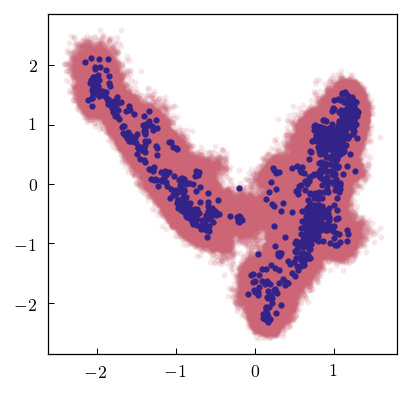

In [22]:
plt.scatter(ivac_arr[ids, 1], ivac_arr[ids, 2], alpha=0.1)
plt.scatter(centers[:, 1], centers[:, 2])

In [23]:
import dill

In [24]:
# with open("../../data/kmeans_feat2_ivac_suppl_01.pkl", mode='wb') as f:
#     dill.dump(kmeans, f)
with open("../../data/kmeans_feat2_ivac_suppl_01.pkl", mode="rb") as f:
    kmeans = dill.load(f)

In [25]:
centers = kmeans.cluster_centers_

In [26]:
# np.save("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy", inds)
inds = np.load("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy")

In [24]:
# with open("../../data/kmeans_feat2_ivac_suppl_01.pkl", mode='wb') as f:
#     dill.dump(kmeans, f)
with open("../../data/kmeans_feat2_ivac_suppl_01.pkl", mode="rb") as f:
    kmeans = dill.load(f)

In [25]:
centers = kmeans.cluster_centers_

In [26]:
# np.save("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy", inds)
inds = np.load("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy")

In [27]:
sb_models = np.load("../../data/models_centroids_feat2.npy")
ivac_models = livac.transform([sb_models])[0]

findfont: Font family ['"Computer Modern Sans Serif"'] not found. Falling back to DejaVu Sans.


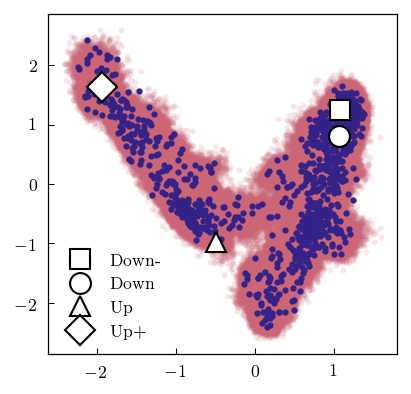

In [28]:
f, ax = plt.subplots()
plt.scatter(ivac_arr[ids, 1], ivac_arr[ids, 2], alpha=0.1)
plt.scatter(centers[:, 1], centers[:, 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

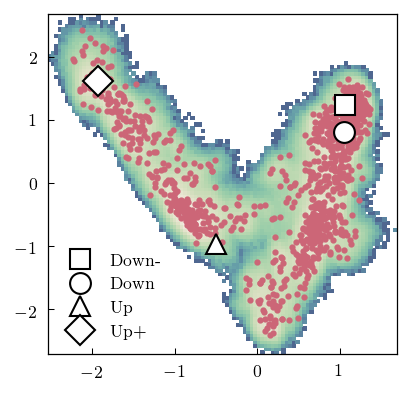

In [29]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
plt.scatter(centers[:, 1], centers[:, 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

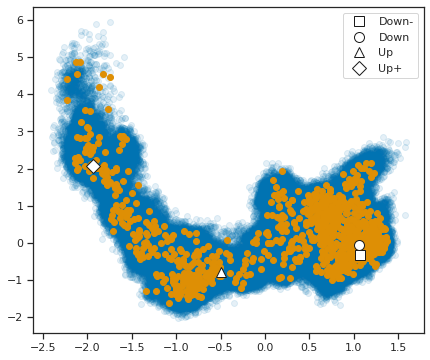

In [19]:
f, ax = plt.subplots()
plt.scatter(ivac_arr[inds, 1], ivac_arr[inds, 3], alpha=0.1)
plt.scatter(centers[:, 1], centers[:, 3])
plotting.plot_models(ax, ivac_models[:, 1:4:2])
plt.legend(["Down-", "Down", "Up", "Up+"])

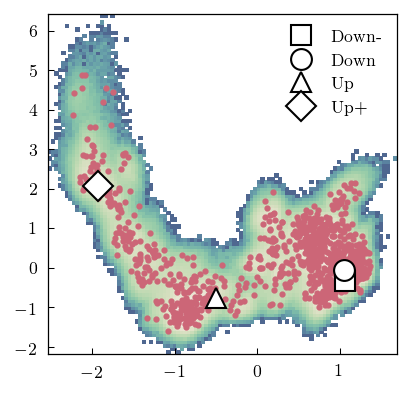

In [30]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:4:2].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
plt.scatter(centers[:, 1], centers[:, 3])
plotting.plot_models(ax, ivac_models[:, 1:4:2])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [31]:
centers.shape

(1000, 10)

## merge clusters manually

In [32]:
# centroids close to down state
down_centers = np.argsort(np.linalg.norm(centers - ivac_models[1, None], axis=1))

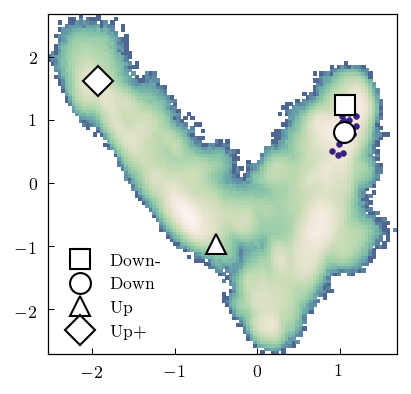

In [33]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
n = 20
plt.scatter(centers[down_centers[:n], 1], centers[down_centers[:n], 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.scatter(centers[down_centers[:n], 1], centers[down_centers[:n], 2])
plt.legend(["Down-", "Down", "Up", "Up+"])

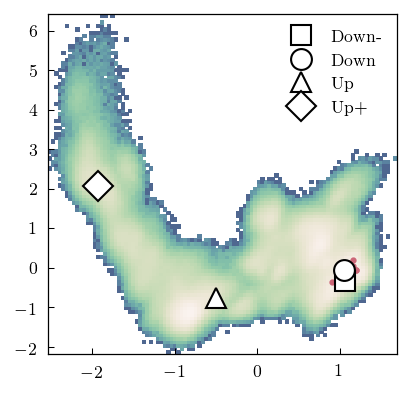

In [34]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:4:2].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
plt.scatter(centers[down_centers[:20], 1], centers[down_centers[:20], 3])
plotting.plot_models(ax, ivac_models[:, 1:4:2])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [35]:
# centroids close to up state
up_centers = np.argsort(np.linalg.norm(centers - ivac_models[2, None], axis=1))

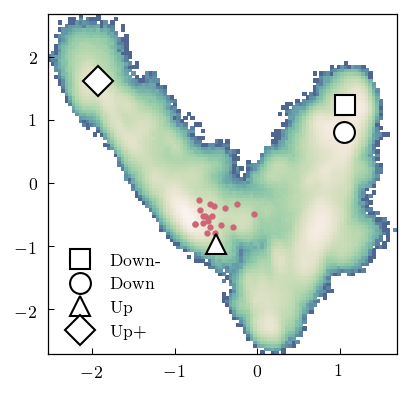

In [36]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
plt.scatter(centers[up_centers[:20], 1], centers[up_centers[:20], 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [37]:
# remove centers
empty_clusters = []
for i in range(1000):
    if np.count_nonzero(inds == i) == 0:
        empty_clusters.append(i)

In [38]:
empty_clusters

[992, 993, 994, 995, 996, 997, 998, 999]

In [39]:
assert len(np.unique(inds)) + len(empty_clusters) == 1000

In [40]:
pruned_centers = list(centers.copy())
for i in empty_clusters[::-1]:
    del pruned_centers[i]

In [41]:
# reassign points
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(pruned_centers)
dtrajs = neighbors.kneighbors(ivac_arr, return_distance=False)

In [42]:
# np.save("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy", dtrajs)
dtrajs = np.load(
    "../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy", allow_pickle=True
)

## compute transition matrix and merge clusters with low stationary probability

In [43]:
split_inds = np.cumsum([len(traj) for traj in cv_trajs])[:-1]
dtrajs = np.split(dtrajs.squeeze(), split_inds)
cmat = msmtools.estimation.count_matrix(dtrajs, lag=100)
tmat = msmtools.estimation.transition_matrix(cmat)

In [44]:
# maximum diagonal elements
max_diag_ids = np.argsort(tmat.diagonal())[::-1]
print(max_diag_ids[:10])

[ 91 630 458 260 742  99 837 103 385 199]


In [42]:
# np.save("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy", dtrajs)
dtrajs = np.load(
    "../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy", allow_pickle=True
)

## compute transition matrix and merge clusters with low stationary probability

In [43]:
split_inds = np.cumsum([len(traj) for traj in cv_trajs])[:-1]
dtrajs = np.split(dtrajs.squeeze(), split_inds)
cmat = msmtools.estimation.count_matrix(dtrajs, lag=100)
tmat = msmtools.estimation.transition_matrix(cmat)

In [44]:
# maximum diagonal elements
max_diag_ids = np.argsort(tmat.diagonal())[::-1]
print(max_diag_ids[:10])

[ 91 630 458 260 742  99 837 103 385 199]


In [45]:
tmat[max_diag_ids[100], max_diag_ids[100]]

0.3670711527854385

In [70]:
# set cutoff for diagonal element
cutoff = 0.25
keep = np.nonzero(tmat.diagonal() > cutoff)
pruned_centers = np.asarray(centers)[keep]

In [71]:
len(pruned_centers)

244

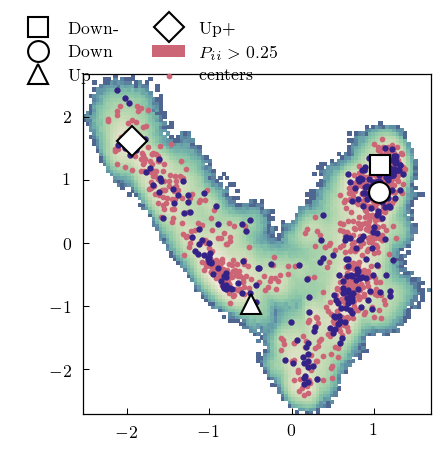

In [76]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
n = 100
ax.scatter(centers[:, 1], centers[:, 2], s=3)
plt.scatter(centers[keep, 1], centers[keep, 2], label="$P_{ii} > 0.5$")
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(
    ["Down-", "Down", "Up", "Up+", f"$P_{{ii}} > {cutoff}$", "centers"],
    ncol=2,
    bbox_to_anchor=(0.6, 1.2),
)

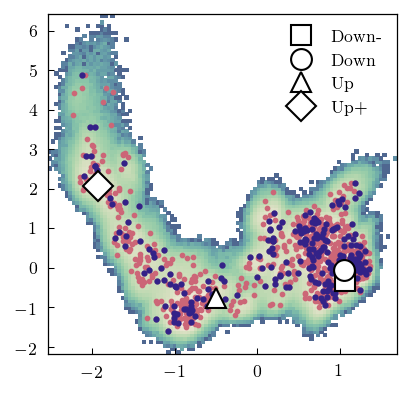

In [77]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:4:2].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
ax.scatter(centers[:, 1], centers[:, 3], s=3)
plt.scatter(centers[keep, 1], centers[keep, 3])
plotting.plot_models(ax, ivac_models[:, 1:4:2])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [78]:
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(pruned_centers)
dtrajs = neighbors.kneighbors(ivac_arr, return_distance=False)

In [79]:
# check new transition matrix
dtrajs = np.split(dtrajs.squeeze(), split_inds)
cmat = msmtools.estimation.count_matrix(dtrajs, lag=100)
tmat = msmtools.estimation.transition_matrix(cmat)

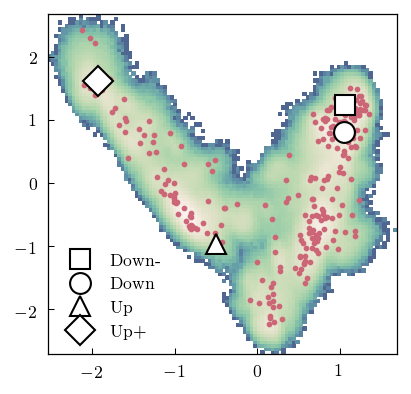

In [81]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
n = 100
ax.scatter(pruned_centers[:, 1], pruned_centers[:, 2], s=3)
# plt.scatter(centers[max_diag_ids[:n], 1], centers[max_diag_ids[:n], 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [82]:
np.save("../../data/raw_feat/feat2_ivac_ind1000_suppl_02_merged.npy", dtrajs)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## cluster clusters

In [108]:
kmeans = MiniBatchKMeans(10, verbose=1)
kmeans.fit(centers)
center_centers = kmeans.cluster_centers_
neighbors_centers = NearestNeighbors(n_neighbors=1)
neighbors_centers.fit(center_centers)

Init 1/3 with method: k-means++
Inertia for init 1/3: 1258.600975
Init 2/3 with method: k-means++
Inertia for init 2/3: 1222.950616
Init 3/3 with method: k-means++
Inertia for init 3/3: 1320.797653
Minibatch iteration 1/1000: mean batch inertia: 3.966697, ewa inertia: 3.966697 
Minibatch iteration 2/1000: mean batch inertia: 4.375892, ewa inertia: 4.048454 
Minibatch iteration 3/1000: mean batch inertia: 4.249938, ewa inertia: 4.088711 
Minibatch iteration 4/1000: mean batch inertia: 4.017828, ewa inertia: 4.074548 
Minibatch iteration 5/1000: mean batch inertia: 4.413964, ewa inertia: 4.142364 
Minibatch iteration 6/1000: mean batch inertia: 4.172987, ewa inertia: 4.148482 
Minibatch iteration 7/1000: mean batch inertia: 4.334639, ewa inertia: 4.185676 
Minibatch iteration 8/1000: mean batch inertia: 3.974607, ewa inertia: 4.143505 
Minibatch iteration 9/1000: mean batch inertia: 4.128020, ewa inertia: 4.140411 
Minibatch iteration 10/1000: mean batch inertia: 4.572548, ewa inertia: 4

NearestNeighbors(n_neighbors=1)

In [109]:
inds = neighbors_centers.kneighbors(centers, return_distance=False)

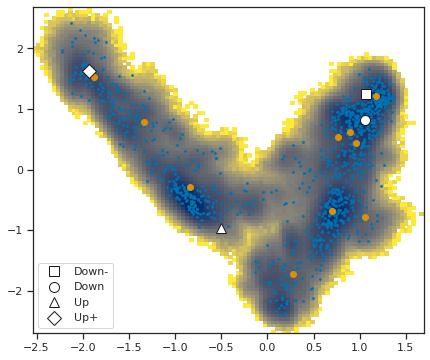

In [110]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.scatter(centers[:, 1], centers[:, 2], s=3)
plt.scatter(center_centers[:, 1], center_centers[:, 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

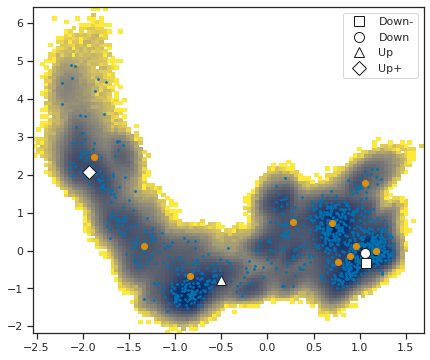

In [111]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:4:2].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
plt.scatter(centers[:, 1], centers[:, 3], s=3)
ax.scatter(center_centers[:, 1], center_centers[:, 3])
plotting.plot_models(ax, ivac_models[:, 1:4:2])
plt.legend(["Down-", "Down", "Up", "Up+"])

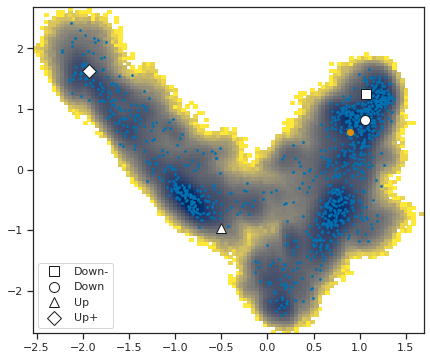

In [162]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.scatter(centers[:, 1], centers[:, 2], s=3)
i = 0
plt.scatter(center_centers[i, 1], center_centers[i, 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [163]:
# centroids close to cluster 9
dense_up_args = np.argsort(np.linalg.norm(centers - center_centers[9], axis=1))
dense_down_args = np.argsort(np.linalg.norm(centers - center_centers[1], axis=1))
dense_down_args_2 = np.argsort(np.linalg.norm(centers - center_centers[0], axis=1))

In [186]:
# reassign indices, removing the top 10 closest centroids to cluster 9
pruned_centers = list(centers.copy())
args = np.concatenate(
    (dense_center_args[:200:2], dense_down_args[:200:2], dense_down_args_2[:400:4])
)
for i in sorted(args, reverse=True):
    print(i)
    del pruned_centers[i]
pruned_centers = np.asarray(pruned_centers)
inds = neighbors.kneighbors(pruned_centers, return_distance=False)

995
992
992
991
990
989
988
986
984
981
980
980
974
972
971
969
968
962
955
951
946
945
944
942
941
941
936
929
927
921
919
913
912
908
896
895
895
894
889
877
875
868
865
865
863
863
861
860
857
854
850
833
831
829
825
814
811
804
801
798
797
794
792
773
771
765
759
755
752
751
746
743
739
737
731
726
724
716
716
715
712
712
709
709
706
700
698
695
693
688
681
675
674
671
670
668
664
663
663
661
657
653
646
644
643
642
642
633
631
630
629
627
611
610
608
606
596
593
577
576
572
571
570
565
564
563
560
557
554
553
552
545
541
537
536
535
532
530
528
527
513
513
504
498
496
496
495
485
485
479
475
475
466
460
455
452
450
450
448
445
440
440
439
437
436
430
423
422
420
419
417
416
412
408
407
400
398
397
396
395
389
388
387
378
375
357
352
346
345
342
339
335
335
322
320
320
318
317
305
303
301
299
290
288
287
283
272
271
261
259
255
254
253
252
249
248
247
246
242
242
240
237
237
236
236
234
230
223
220
218
217
213
213
206
204
203
202
198
193
189
188
182
179
175
175
174
173
172
170
161


In [187]:
pruned_centers.shape

(700, 10)

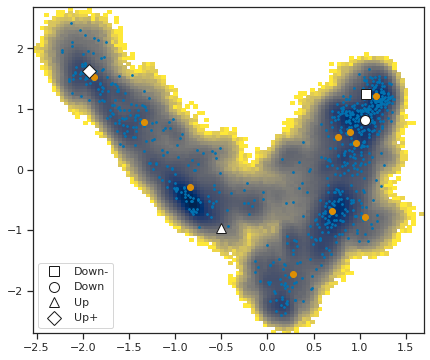

In [188]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
ax.scatter(pruned_centers[:, 1], pruned_centers[:, 2], s=3)
plt.scatter(center_centers[:, 1], center_centers[:, 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

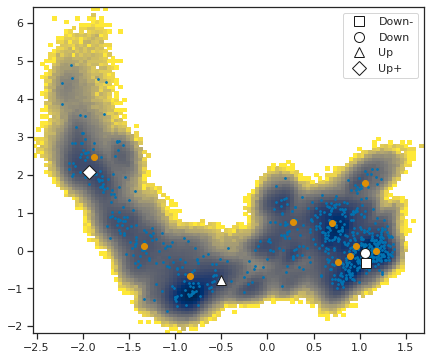

In [189]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:4:2].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap="cividis_r", norm=mpl.colors.LogNorm())
plt.scatter(pruned_centers[:, 1], pruned_centers[:, 3], s=3)
ax.scatter(center_centers[:, 1], center_centers[:, 3])
plotting.plot_models(ax, ivac_models[:, 1:4:2])
plt.legend(["Down-", "Down", "Up", "Up+"])

# split clusters with high stationary probability

In [85]:
k = 200
kmeans = MiniBatchKMeans(k)
kmeans.fit(ivac_arr)
centers = kmeans.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [86]:
dtrajs = neighbors.kneighbors(ivac_arr, return_distance=False)

In [87]:
with open("../../data/kmeans200_feat2_ivac_suppl_01.pkl", mode="wb") as f:
    dill.dump(kmeans, f)
# with open("../../data/kmeans_feat2_ivac_suppl_01.pkl", mode='rb') as f:
#     kmeans = dill.load(f)

In [88]:
centers = kmeans.cluster_centers_

In [89]:
np.save("../../data/raw_feat/feat2_ivac_ind200_suppl_02.npy", dtrajs)
# inds = np.load("../../data/raw_feat/feat2_ivac_ind1000_suppl_02.npy")

In [101]:
# dtrajs = np.split(dtrajs.squeeze(), split_inds)
cmat = msmtools.estimation.count_matrix(dtrajs, lag=100)
tmat = msmtools.estimation.transition_matrix(cmat)

In [102]:
# maximum diagonal elements
max_diag_ids = np.argsort(tmat.diagonal())[::-1]
print(max_diag_ids[:10])

[ 55 118 169 101  26  52  46 172 107  21]


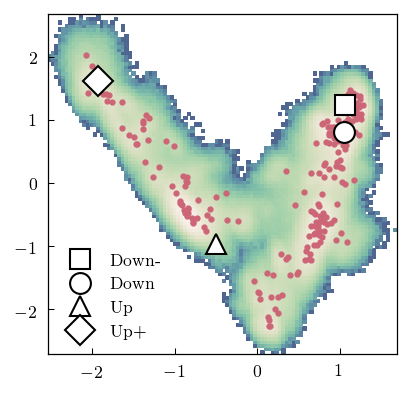

In [92]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
plt.scatter(centers[:, 1], centers[:, 2])
plotting.plot_models(ax, ivac_models[:, 1:3])
plt.legend(["Down-", "Down", "Up", "Up+"])

In [117]:
# set cutoff for diagonal element
cutoff = 0.5
keep = np.nonzero(tmat.diagonal() > cutoff)
to_split_centers = centers[keep]

In [118]:
len(to_split_centers)

80

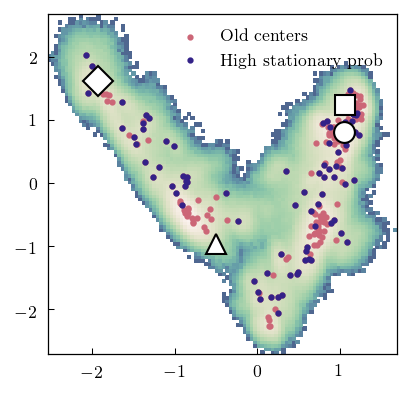

In [120]:
f, ax = plt.subplots()
hist, xe, ye = np.histogram2d(*ivac_arr[..., 1:3].T, bins=100, density=True)
h = ax.pcolor(xe, ye, hist.T, cmap=cm_seq, norm=mpl.colors.LogNorm())
plt.scatter(centers[:, 1], centers[:, 2], label="Old centers")
plt.scatter(
    to_split_centers[:, 1], to_split_centers[:, 2], label="High stationary prob"
)
plt.legend()
plotting.plot_models(ax, ivac_models[:, 1:3])
# plt.legend(['Down-', 'Down', 'Up', 'Up+'])

In [ ]:
def split_cluster:
    